# How to use Refactored WEAC_2

In [1]:
# Auto reload modules
%load_ext autoreload
%autoreload all

In [2]:
import os
import sys
# Third party imports
import numpy as np
import matplotlib.pyplot as plt


### Define slab layering
---

#### i) from database
Choose one of the following profiles (a-f) from the database

<img src="../img/profiles.png" width="500"/>

where the illustrated bar lengths correspond to the following densities of the layers (longer is denser): 

| Type   | Density    |
|--------|------------|
| Soft   | 180 kg/m^3 |
| Medium | 270 kg/m^3 |
| Hard   | 350 kg/m^3 |

Layers of the database profile are 120 mm thick.

#### ii) define a custom slab profile

Define a custom slab profile as a 2D array where the columns are density (kg/m^2) and layer thickness (mm). One row corresponds to one layer counted from top (below surface) to bottom (above weak layer):

<img src="../img/layering.png" width="250"/>

In [3]:
from weac.components import Layer, Config, ScenarioConfig, ModelInput, WeakLayer, Segment
from weac.utils.misc import load_dummy_profile

from weac.core.system_model import SystemModel
from weac.analysis.plotter import Plotter


### Analyze skier-induced stresses and deformations
---

In [4]:
# Example with two segements, one skier load
# (between segments 1 & 2) and no crack.

#                   |
#                   v
# +-----------------+-----------------+
# |                 |                 |
# |        1        |        2        |
# |                 |                 |
# +-----------------+-----------------+
#  |||||||||||||||||||||||||||||||||||
# --------------------------------------

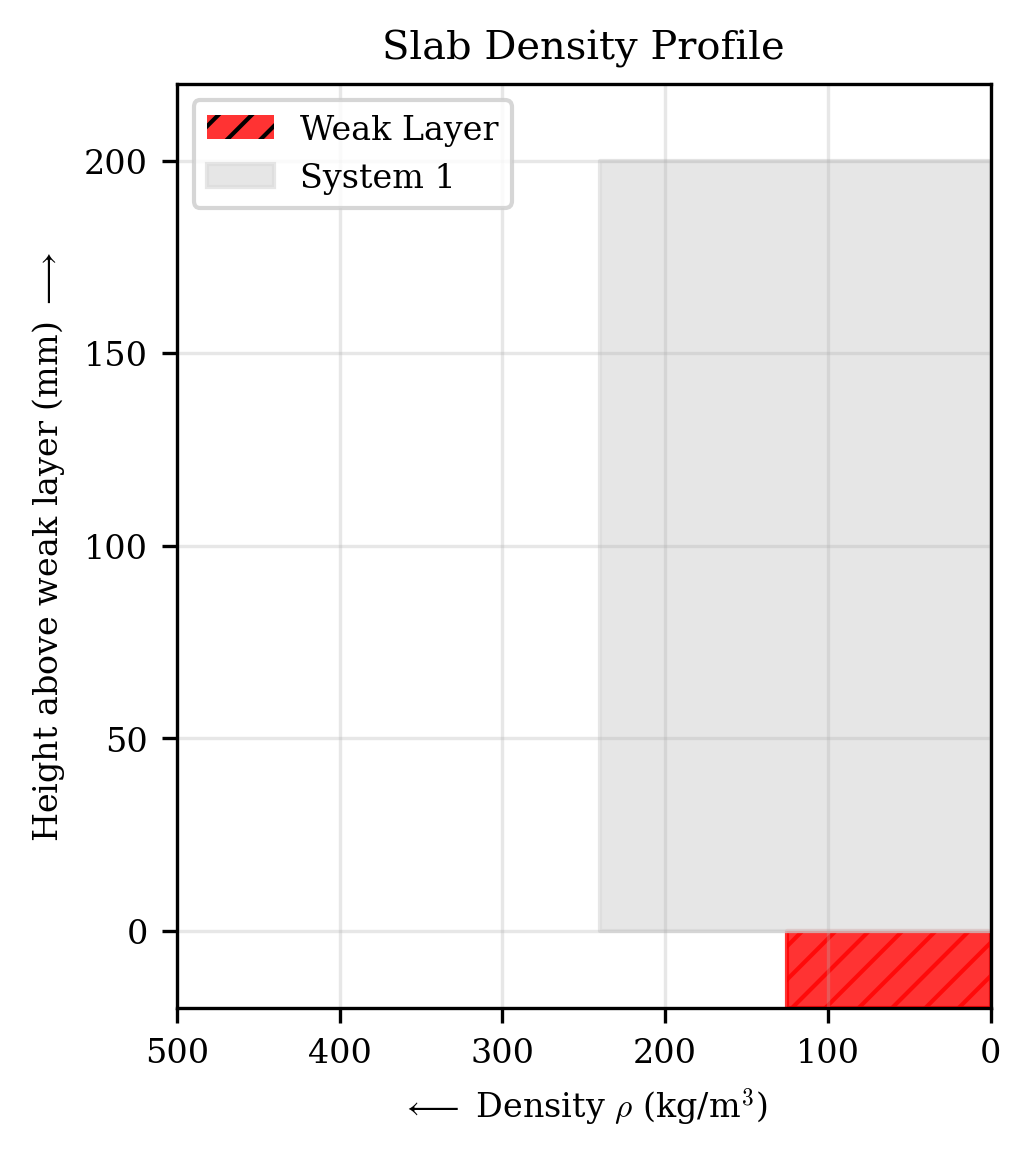

In [5]:
from weac.analysis.analyzer import Analyzer

# Default slab profile
default_slab_layers = [
    Layer(rho=240, h=200),
]
skier_config = ScenarioConfig(
    system_type='skier',
    phi=30,
)
skier_segments = [
    Segment(length=5000, has_foundation=True, m=0),
    Segment(length=0, has_foundation=False, m=80),
    Segment(length=0, has_foundation=False, m=0),
    Segment(length=5000, has_foundation=True, m=0),
]
skier_input = ModelInput(
    scenario_config=skier_config,
    layers=default_slab_layers,
    segments=skier_segments,
)
# One skier on homogeneous default slab (240 kg/m^3, 200 mm)
skier_model = SystemModel(
    model_input=skier_input,
)

skier_plotter = Plotter()
fig = skier_plotter.plot_slab_profile(
    weak_layers=skier_model.weak_layer,
    slabs=skier_model.slab,
)

skier_analyzer = Analyzer(skier_model)
xsl_skier, z_skier, xwl_skier = skier_analyzer.rasterize_solution(mode="cracked")


#### Visualize slab deformations (contour plot)

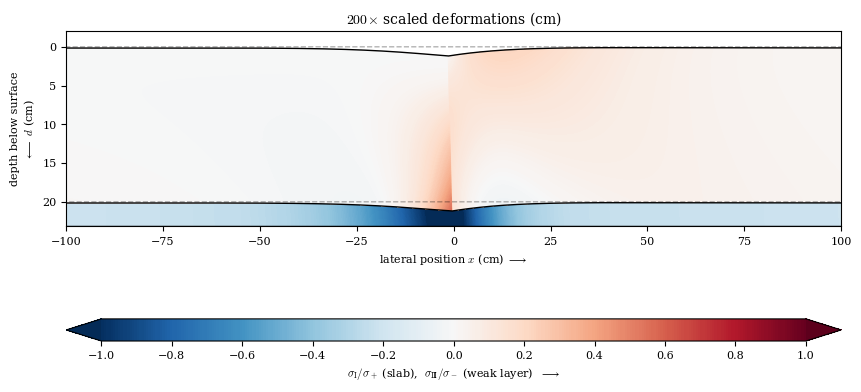

In [6]:
fig = skier_plotter.plot_deformed(xsl_skier, xwl_skier, z_skier, skier_analyzer, scale=200, window=200, aspect=2, field='principal')

#### Plot slab displacements

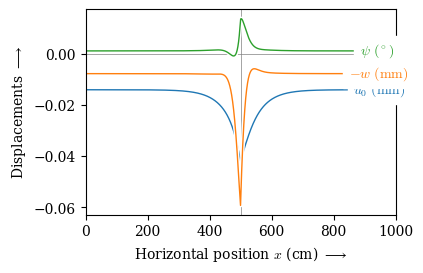

In [7]:
skier_plotter.plot_displacements(skier_analyzer, x=xsl_skier, z=z_skier)

#### Plot weak-layer stresses

--- Analyzer Call Statistics ---
- rasterize_solution: called 1 times, total time 0.1174s, avg time 0.1174s
- principal_stress_slab: called 1 times, total time 0.0226s, avg time 0.0226s
- Szz: called 1 times, total time 0.0108s, avg time 0.0108s
- Txz: called 1 times, total time 0.0074s, avg time 0.0074s
- Sxx: called 1 times, total time 0.0013s, avg time 0.0013s
- get_zmesh: called 5 times, total time 0.0006s, avg time 0.0001s
- principal_stress_weaklayer: called 1 times, total time 0.0001s, avg time 0.0001s
---------------------------------


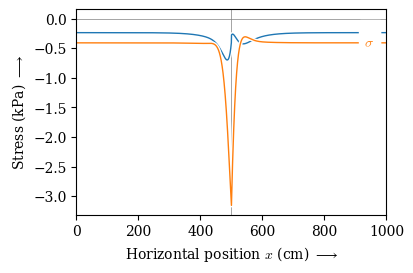

In [8]:
skier_plotter.plot_stresses(skier_analyzer, x=xwl_skier, z=z_skier)
skier_analyzer.print_call_stats()

### Propagation saw test
---

In [9]:
# Example with a crack cut from the right-hand side.

# +-----------------------------+-----+
# |                             |     |
# |             1               |  2  |
# |                             |     |
# +-----------------------------+-----+
#  |||||||||||||||||||||||||||||
# --------------------------------------

In [10]:
# PST Profile
pst_layers = [
    Layer(rho=170, h=100),
    Layer(rho=190, h=40),
    Layer(rho=230, h=130),
    Layer(rho=250, h=20),
    Layer(rho=210, h=70),
    Layer(rho=380, h=20),
    Layer(rho=280, h=100),
]
pst_config = ScenarioConfig(
    system_type='pst-',
    phi=-38,
    crack_length=300,
)
pst_segments = [
    Segment(length=2200, has_foundation=True, m=0),
    Segment(length=300, has_foundation=False, m=0),
]
pst_input = ModelInput(
    scenario_config=pst_config,
    layers=pst_layers,
    segments=pst_segments,
)
pst_config = Config(
    touchdown=False,
)

pst_cut_right = SystemModel(
    model_input=pst_input,
    config=pst_config,
)

if pst_cut_right.slab_touchdown is not None:
    touchdown_distance = pst_cut_right.slab_touchdown.touchdown_distance
    print(f"Touchdown distance: {touchdown_distance} mm")
    touchdown_mode = pst_cut_right.slab_touchdown.touchdown_mode
    print(f"Touchdown mode: {touchdown_mode}")

pst_cut_right_analyzer = Analyzer(pst_cut_right)
xsl_pst, z_pst, xwl_pst = pst_cut_right_analyzer.rasterize_solution(mode="cracked")
print(xsl_pst)


[0.000000e+00 6.250000e-01 1.250000e+00 ... 2.498750e+03 2.499375e+03
 2.500000e+03]


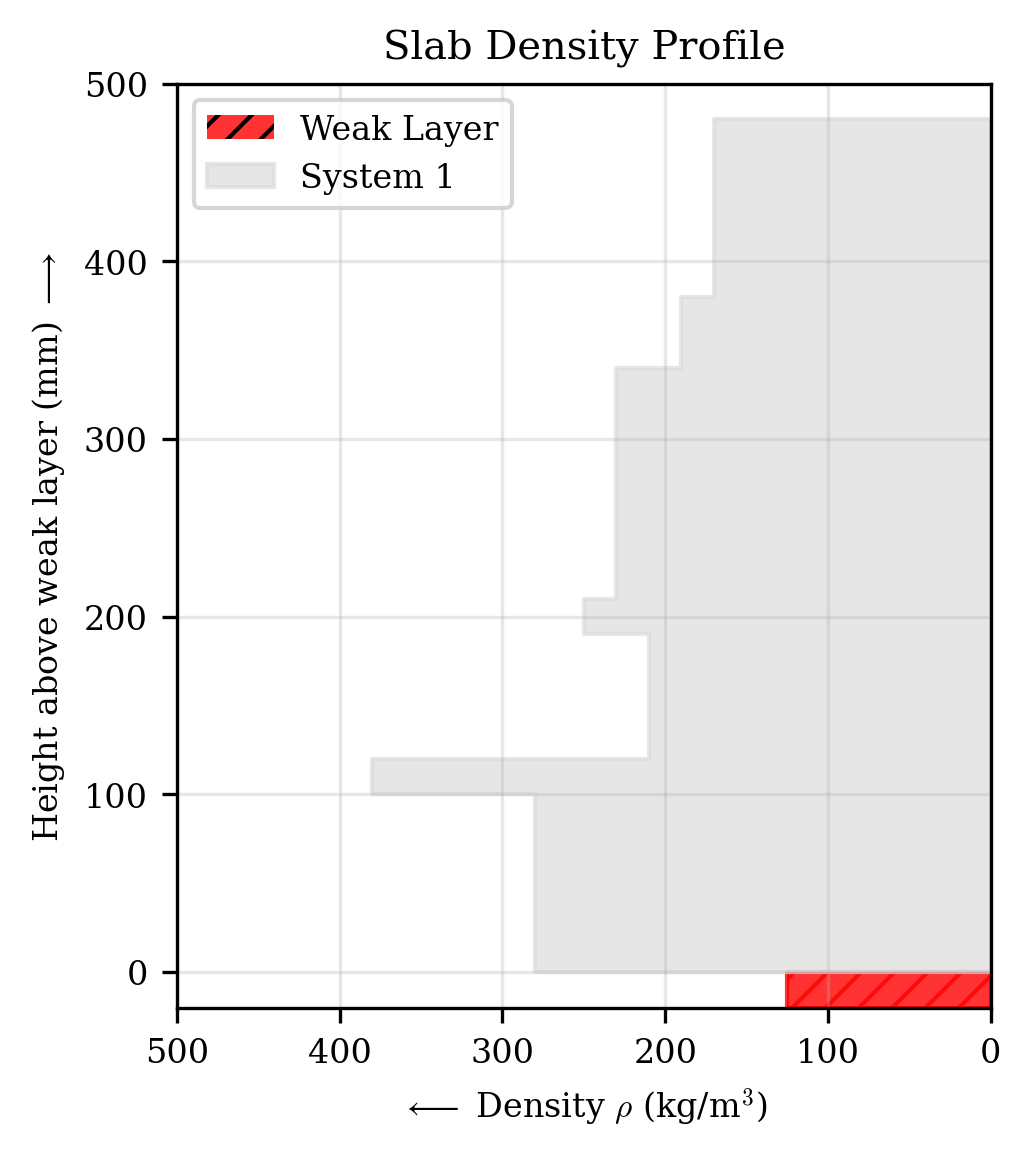

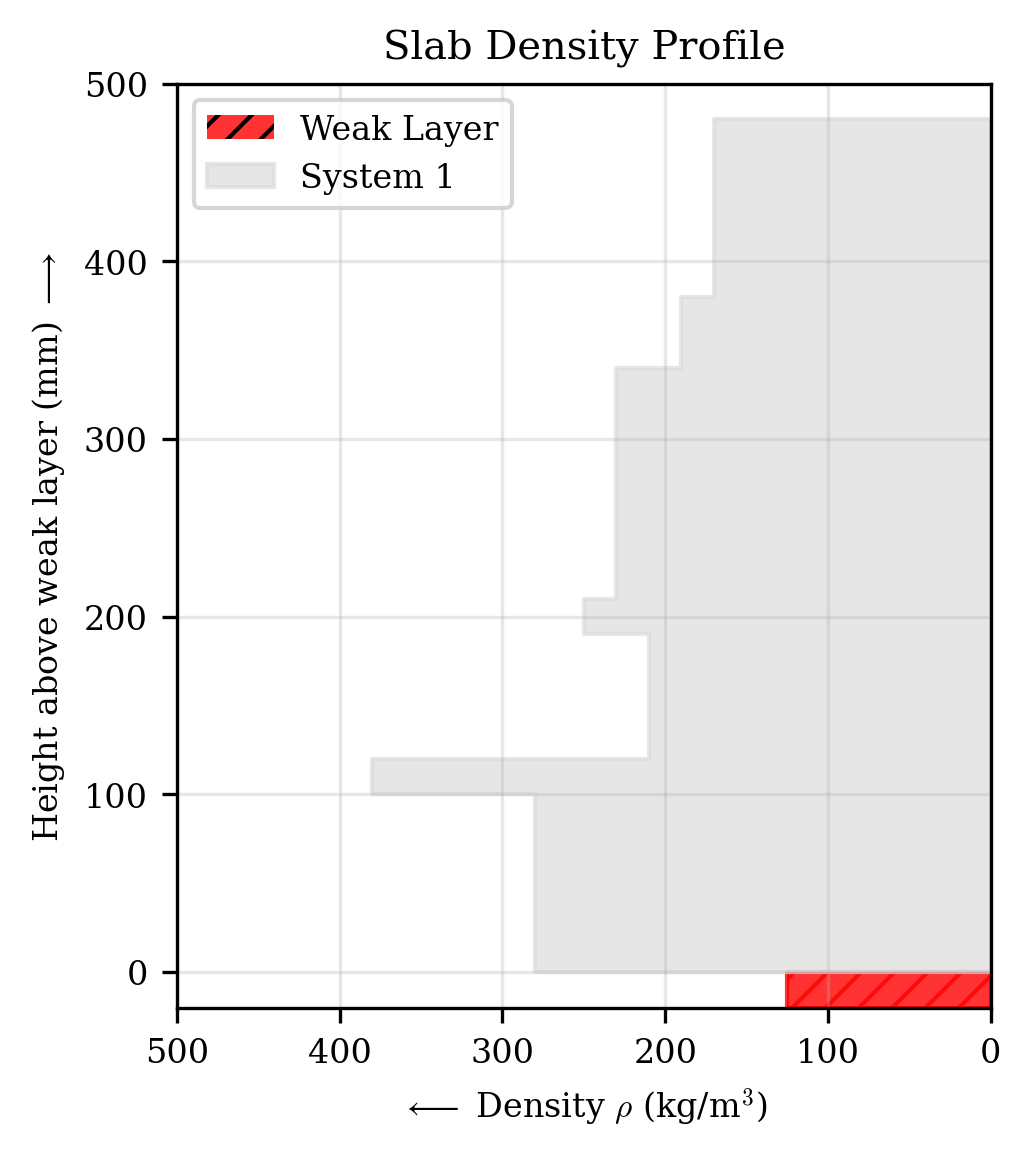

In [11]:
pst_cut_right_plotter = Plotter()
pst_cut_right_plotter.plot_slab_profile(
    weak_layers=pst_cut_right.weak_layer,
    slabs=pst_cut_right.slab,
)

#### Visualize slab deformations (contour plot)

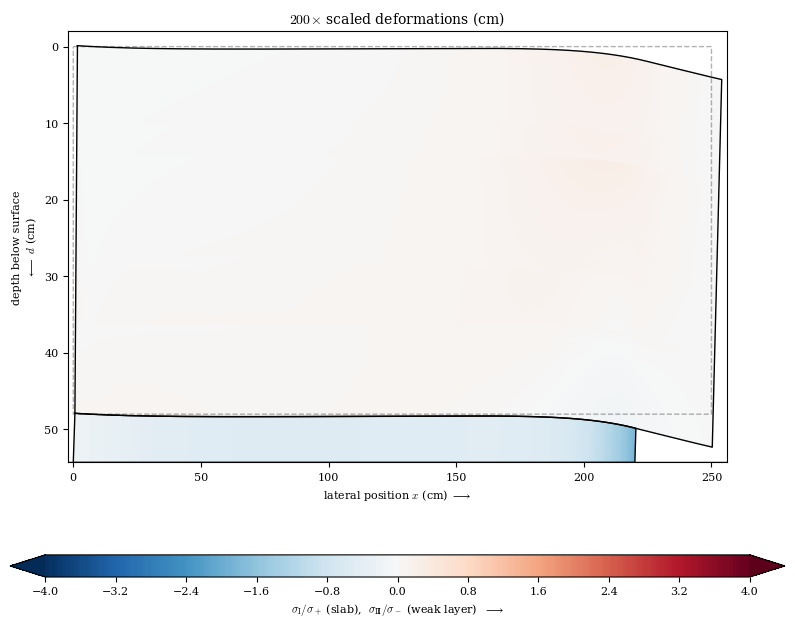

In [12]:
fig = pst_cut_right_plotter.plot_deformed(xsl_pst, xwl_pst, z_pst, pst_cut_right_analyzer, scale=200, aspect=3, field='principal')

#### Plot slab deformations

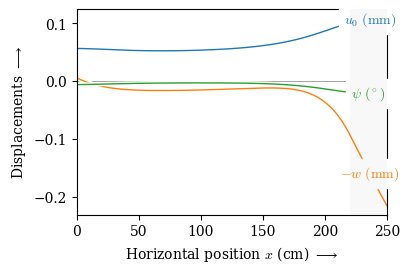

In [13]:
pst_cut_right_plotter.plot_displacements(pst_cut_right_analyzer, x=xsl_pst, z=z_pst)

#### Plot weak-layer stresses

--- Analyzer Call Statistics ---
- rasterize_solution: called 1 times, total time 0.1198s, avg time 0.1198s
- principal_stress_slab: called 1 times, total time 0.0476s, avg time 0.0476s
- Szz: called 1 times, total time 0.0236s, avg time 0.0236s
- Txz: called 1 times, total time 0.0123s, avg time 0.0123s
- Sxx: called 1 times, total time 0.0033s, avg time 0.0033s
- get_zmesh: called 5 times, total time 0.0013s, avg time 0.0003s
- principal_stress_weaklayer: called 1 times, total time 0.0001s, avg time 0.0001s
---------------------------------


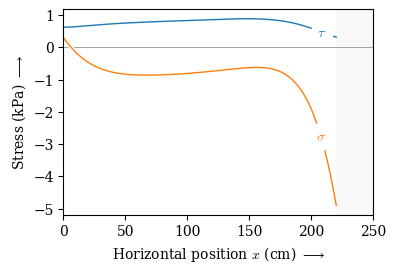

In [14]:
pst_cut_right_plotter.plot_stresses(pst_cut_right_analyzer, x=xwl_pst, z=z_pst)
pst_cut_right_analyzer.print_call_stats()

In [15]:
Gdif = pst_cut_right_analyzer.differential_ERR()
Ginc = pst_cut_right_analyzer.incremental_ERR()
print("Gdif", Gdif)
print("Ginc", Ginc)

Gdif [2.27724548e-04 2.25296601e-04 2.42794667e-06]
Ginc [ 1.07401758e-04  1.11156619e-04 -3.75486071e-06]


### Energy release rate in propagation saw tests
---

In [16]:
inclination = 30                        # Slope inclination (°)
n = 50                                  # Number of crack increments


scenario_config = pst_cut_right.scenario.scenario_config
scenario_config.phi = inclination
pst_cut_right.update_scenario(
    scenario_config=scenario_config,
)
pst_cut_right_analyzer = Analyzer(pst_cut_right)

da = np.linspace(1e-6, 400, num=n)
Gdif = np.zeros([3, n])
Ginc = np.zeros([3, n])

for i in range(n):
    L = 1200 - da[i]
    pst_ERR_segments = [
        Segment(length=L, has_foundation=True, m=0),
        Segment(length=da[i], has_foundation=False, m=0),
    ]
    pst_cut_right.update_scenario(
        segments=pst_ERR_segments,
    )
    
    Gdif[:, i] = pst_cut_right_analyzer.differential_ERR()
    Ginc[:, i] = pst_cut_right_analyzer.incremental_ERR()


#### Plot differential energy release rate

--- Analyzer Call Statistics ---
- incremental_ERR: called 50 times, total time 0.1933s, avg time 0.0039s
- differential_ERR: called 50 times, total time 0.0319s, avg time 0.0006s
---------------------------------


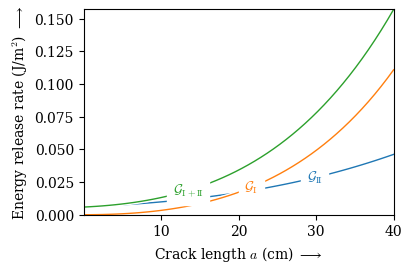

In [17]:

pst_cut_right_plotter.plot_ERR_modes(pst_cut_right_analyzer, da, Gdif, kind='dif')
pst_cut_right_analyzer.print_call_stats()

### Multiple skiers
----

In [18]:
# Example with six segements, two skier loads (between
# segments 1 & 2 and 2 & 3) and a crack under segments
# 4 and 5

#           |   |
#           v   v
# +---------+---+-----+---+---+-------+
# |         |   |     |   |   |       |
# |    1    | 2 |  3  | 4 | 5 |   6   |
# |         |   |     |   |   |       |
# +---------+---+-----+---+---+-------+
#  |||||||||||||||||||         |||||||
# --------------------------------------

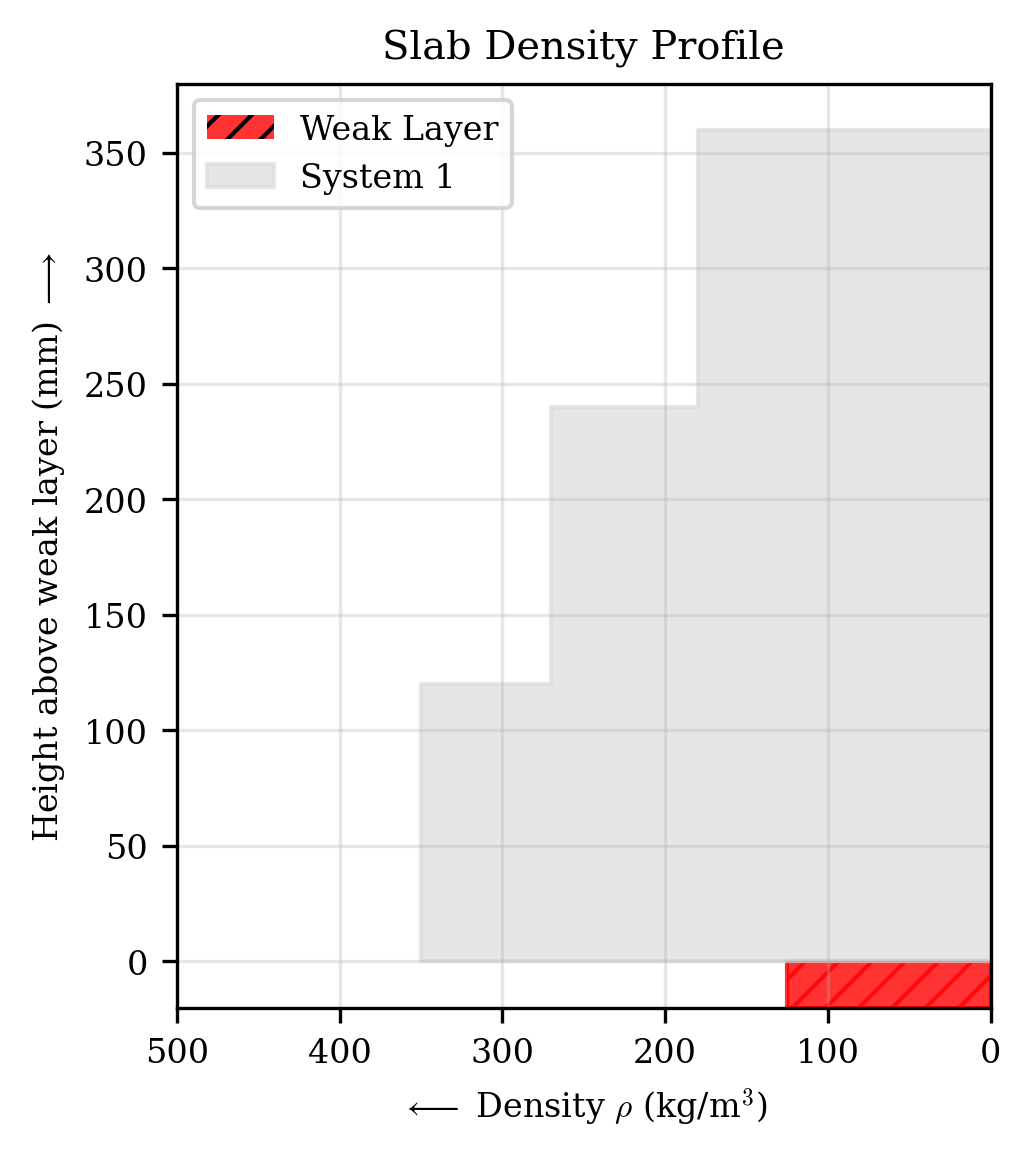

In [19]:
# Skiers on B Profile
skiers_on_b_layers = load_dummy_profile('b')
skiers_config = ScenarioConfig(
    system='skiers',
    phi=-20,
)
skiers_segments = [
    Segment(length=5e3, has_foundation=True, m=80),
    Segment(length=10e2, has_foundation=True, m=80),
    Segment(length=25e2, has_foundation=True, m=0),
    Segment(length=3e2, has_foundation=False, m=0),
    Segment(length=3e2, has_foundation=False, m=0),
    Segment(length=5e3, has_foundation=True, m=0),
]
skiers_on_b_input = ModelInput(
    scenario_config=skiers_config,
    layers=skiers_on_b_layers,
    segments=skiers_segments,
)
# Multiple skiers on slab with database profile B
skiers_on_B = SystemModel(
    model_input=skiers_on_b_input,
)

skiers_on_B_analyzer = Analyzer(skiers_on_B)
xsl_skiers, z_skiers, xwl_skiers = skiers_on_B_analyzer.rasterize_solution(mode="cracked")

skiers_on_B_plotter = Plotter()
fig =skiers_on_B_plotter.plot_slab_profile(
    weak_layers=skiers_on_B.weak_layer,
    slabs=skiers_on_B.slab,
)

#### Visualize slab deformations (contour plot)

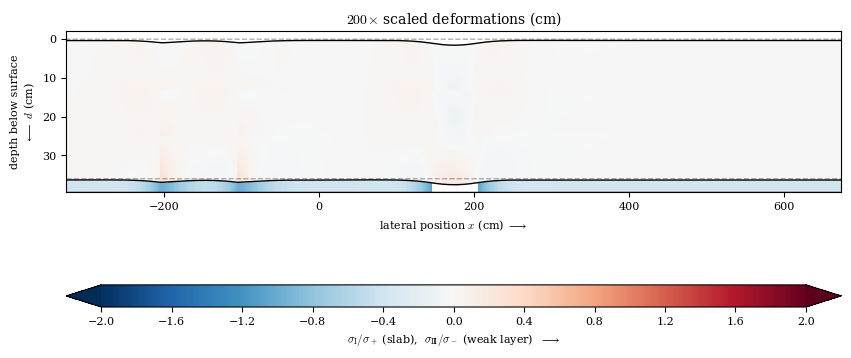

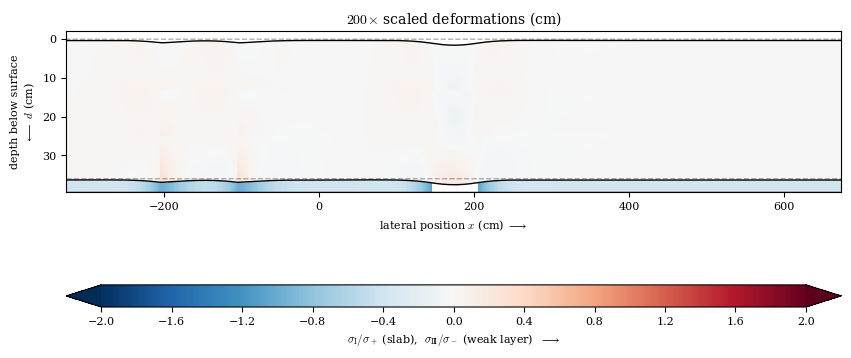

In [20]:
skiers_on_B_plotter.plot_deformed(
    xsl_skiers, xwl_skiers, z_skiers, skiers_on_B_analyzer, scale=200, window=1e3, aspect=5, field='principal')

#### Plot slab displacements

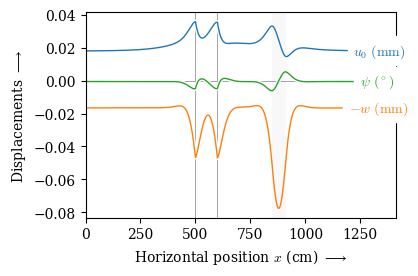

In [21]:
skiers_on_B_plotter.plot_displacements(skiers_on_B_analyzer, x=xsl_skiers, z=z_skiers)

#### Plot weak-layer stresses

--- Analyzer Call Statistics ---
- rasterize_solution: called 1 times, total time 0.1261s, avg time 0.1261s
- principal_stress_slab: called 1 times, total time 0.0640s, avg time 0.0640s
- Szz: called 1 times, total time 0.0335s, avg time 0.0335s
- Txz: called 1 times, total time 0.0169s, avg time 0.0169s
- Sxx: called 1 times, total time 0.0045s, avg time 0.0045s
- get_zmesh: called 5 times, total time 0.0015s, avg time 0.0003s
- principal_stress_weaklayer: called 1 times, total time 0.0002s, avg time 0.0002s
---------------------------------


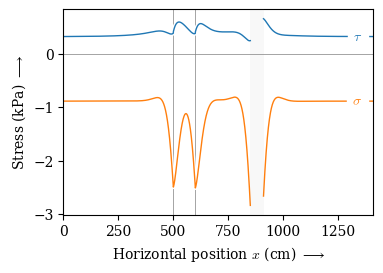

In [22]:
skiers_on_B_plotter.plot_stresses(skiers_on_B_analyzer, x=xwl_skiers, z=z_skiers)
skiers_on_B_analyzer.print_call_stats()

#### Compare all outputs

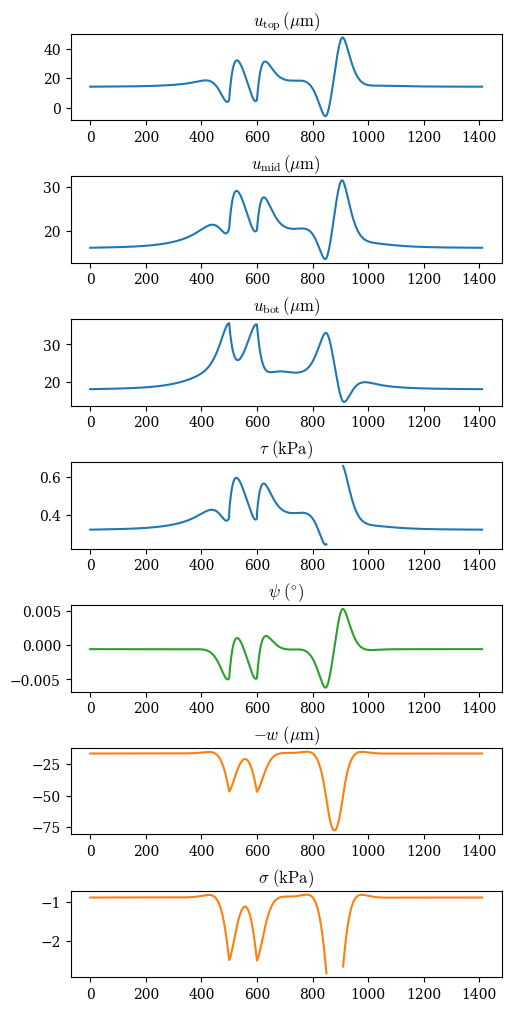

In [23]:
# === WEAK-LAYER OUTPUTS ===================================================

# Use only x-coordinates of bedded segments (xb)
x, z = xwl_skiers, z_skiers
xwl_cm = x / 10

# Compute stresses in kPa
tau = skiers_on_B_analyzer.sm.fq.tau(Z=z, unit='kPa')
tau = np.where(~np.isnan(x), tau, np.nan)
sig = skiers_on_B_analyzer.sm.fq.sig(Z=z, unit='kPa')
sig = np.where(~np.isnan(x), sig, np.nan)

# Compute deformations in um and degrees
top = skiers_on_B_analyzer.sm.slab.H
mid = skiers_on_B_analyzer.sm.slab.H / 2
bot = 0

x, z = xsl_skiers, z_skiers
xsl_cm = x /10

w = skiers_on_B_analyzer.sm.fq.w(Z=z, unit='um')
u_top = skiers_on_B_analyzer.sm.fq.u(Z=z, h0=top, unit='um')
u_mid = skiers_on_B_analyzer.sm.fq.u(Z=z, h0=mid, unit='um')
u_bot = skiers_on_B_analyzer.sm.fq.u(Z=z, h0=bot, unit='um')
psi = skiers_on_B_analyzer.sm.fq.psi(Z=z, unit='deg')


# # === ASSEMBLE ALL OUTPUTS INTO LISTS =======================================

outputs = [u_top, u_mid, u_bot, tau, psi, -w, sig]

names = [
    r'$u_\mathrm{top}\,(\mu\mathrm{m})$',
    r'$u_\mathrm{mid}\,(\mu\mathrm{m})$',
    r'$u_\mathrm{bot}\,(\mu\mathrm{m})$',
    r'$\tau\ (\mathrm{kPa})$',
    r'$\psi\ (\!^\circ\!)$',
    r'$-w\ (\mu\mathrm{m})$',
    r'$\sigma\ (\mathrm{kPa})$'
]

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
coloridx = [0, 0, 0, 0, 2, 1, 1]

# === PLOT ALL OUTPUTS ======================================================

fig, axs = plt.subplots(7, 1, constrained_layout=True, figsize=(5,10))
for i, ax in enumerate(fig.get_axes()):
    ax.plot(xsl_cm, outputs[i], color=colors[coloridx[i]])
    ax.set_title(names[i])

### Checking criteria for anticrack nucleation and crack propagation

In [24]:
from weac.components.criteria_config import CriteriaConfig
from weac.analysis.criteria_evaluator import CriteriaEvaluator, CoupledCriterionResult, FindMinimumForceResult

In [25]:
# Define test parameters
layers = [
    Layer(rho=170, h=100),
    Layer(rho=190, h=40),
    Layer(rho=230, h=130),
    Layer(rho=250, h=20),
    Layer(rho=210, h=70),
    Layer(rho=380, h=20),
    Layer(rho=280, h=100),
]
scenario_config = ScenarioConfig(
    system_type='skier',
    phi=30,
)
segments = [
    Segment(length=240000, has_foundation=True, m=0),
    Segment(length=0, has_foundation=False, m=75),
    Segment(length=0, has_foundation=False, m=0),
    Segment(length=240000, has_foundation=False, m=0),
]
weak_layer = WeakLayer(
    rho=150,
    h=30,
    E=0.25,
)
criteria_config = CriteriaConfig(
    stress_envelope_method='adam_unpublished',
    scaling_factor=1,
    order_of_magnitude=1,
)
model_input = ModelInput(
    scenario_config=scenario_config,
    layers=layers,
    segments=segments,
    weak_layer=weak_layer,
    criteria_config=criteria_config,
)

sys_model = SystemModel(
    model_input=model_input,
)

criteria_evaluator = CriteriaEvaluator(
    criteria_config=criteria_config,
)

results: FindMinimumForceResult = criteria_evaluator.find_minimum_force(
    system=sys_model
)

print("Minimum force:", results.success)
print("Skier weight:", results.critical_skier_weight)
print("Distance to failure:", results.max_dist_stress)
print("Min Distance to failure:", results.min_dist_stress)
print("Minimum force iterations:", results.iterations)

Minimum force: True
Skier weight: 490.61566658208375
Distance to failure: 0.9999999999303159
Min Distance to failure: 0.03412762568741824
Minimum force iterations: None


   - Generating stress envelope...


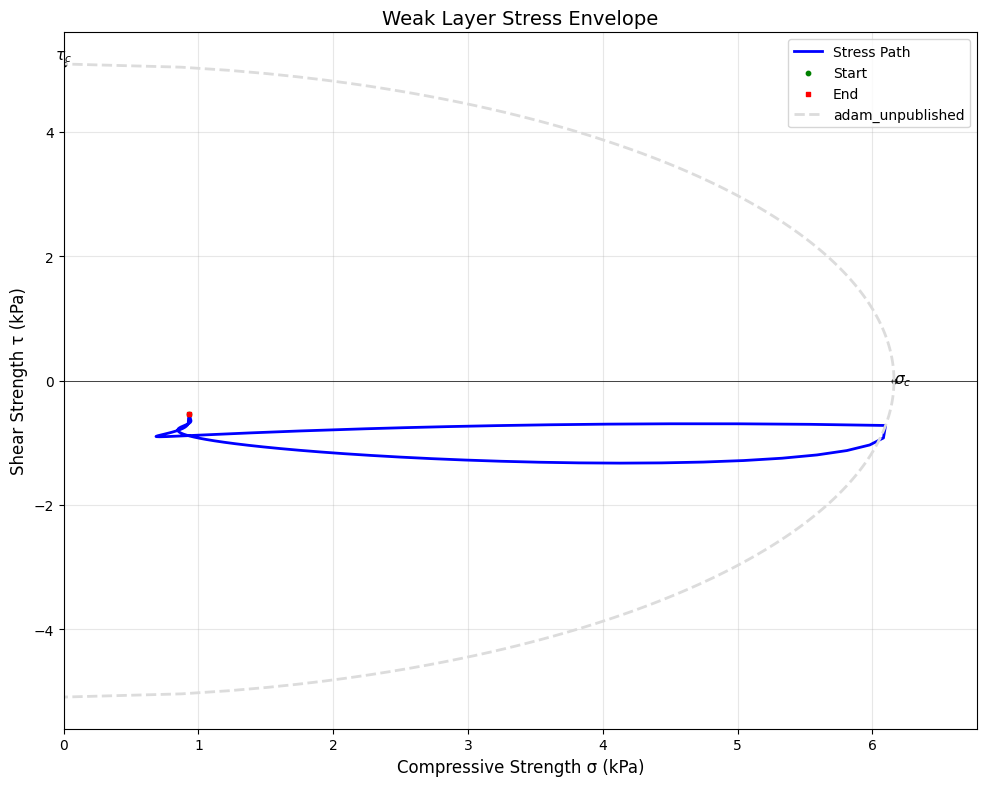

In [26]:

print("   - Generating stress envelope...")
plotter = Plotter()
plotter.plot_stress_envelope(
    system_model=sys_model,
    criteria_evaluator=criteria_evaluator,
    all_envelopes=False,
    filename="stress_envelope",
)

In [27]:
# Define test parameters
layers = [
    Layer(rho=170, h=100),
    Layer(rho=190, h=40),
    Layer(rho=230, h=130),
    Layer(rho=250, h=20),
    Layer(rho=210, h=70),
    Layer(rho=380, h=20),
    Layer(rho=280, h=100),
]
scenario_config = ScenarioConfig(
    system_type='skier',
    phi=30,
)
segments = [
    Segment(length=240000, has_foundation=True, m=0),
    Segment(length=0, has_foundation=False, m=75),
    Segment(length=0, has_foundation=False, m=0),
    Segment(length=240000, has_foundation=False, m=0),
]
weak_layer = WeakLayer(
    rho=150,
    h=30,
    E=0.25,
)
criteria_config = CriteriaConfig(
    stress_envelope_method='adam_unpublished',
    scaling_factor=1,
    order_of_magnitude=1,
)
model_input = ModelInput(
    scenario_config=scenario_config,
    layers=layers,
    segments=segments,
    weak_layer=weak_layer,
    criteria_config=criteria_config,
)

sys_model = SystemModel(
    model_input=model_input,
)

criteria_evaluator = CriteriaEvaluator(
    criteria_config=criteria_config,
)

results: CoupledCriterionResult = criteria_evaluator.evaluate_coupled_criterion(
    system=sys_model
)

print("Algorithm convergence:", results.converged)
print("Message:", results.message)
print("Critical skier weight:", results.critical_skier_weight)
print("Crack length:", results.crack_length)
print("Stress failure envelope:", results.max_dist_stress)
print("G delta:", results.g_delta)
print("Iterations:", results.iterations)

Algorithm convergence: True
Message: Fracture governed by pure stress criterion.
Critical skier weight: 493.0683850240784
Crack length: 1.0
Stress failure envelope: 1.012272470764964
G delta: 760.8448858659796
Iterations: 1


   - Generating stress envelope...


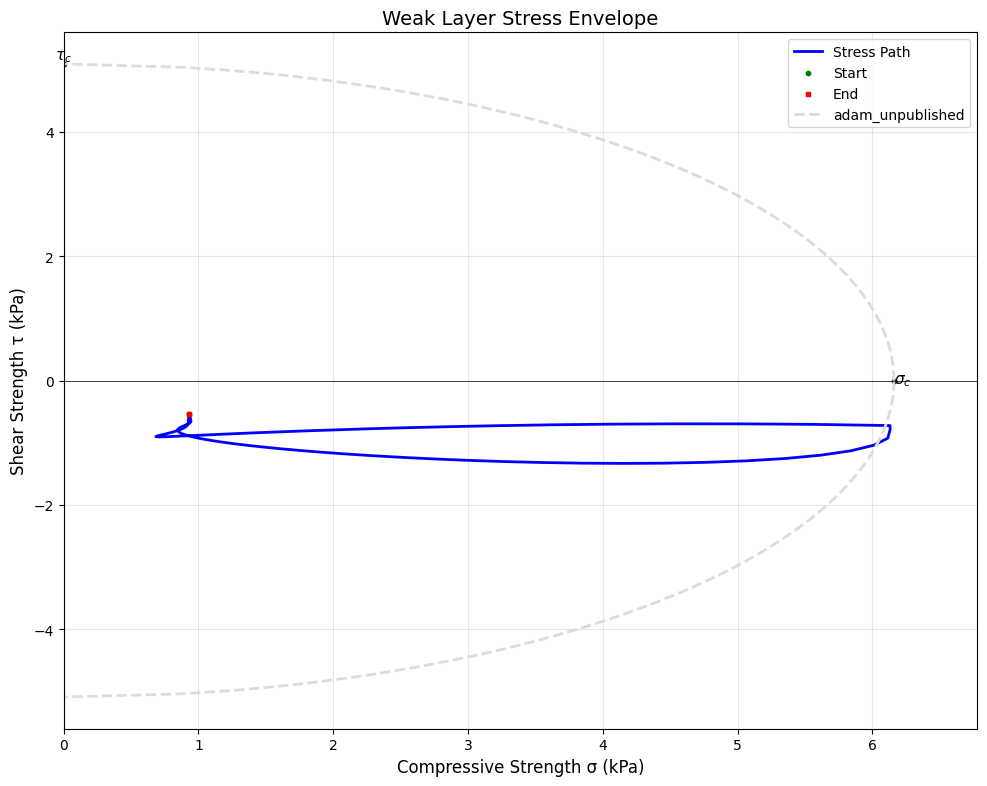

In [28]:
print("   - Generating stress envelope...")
plotter = Plotter()
plotter.plot_stress_envelope(
    system_model=sys_model,
    criteria_evaluator=criteria_evaluator,
    all_envelopes=False,
    filename="stress_envelope",
)

   - Generating fracture toughness envelope...


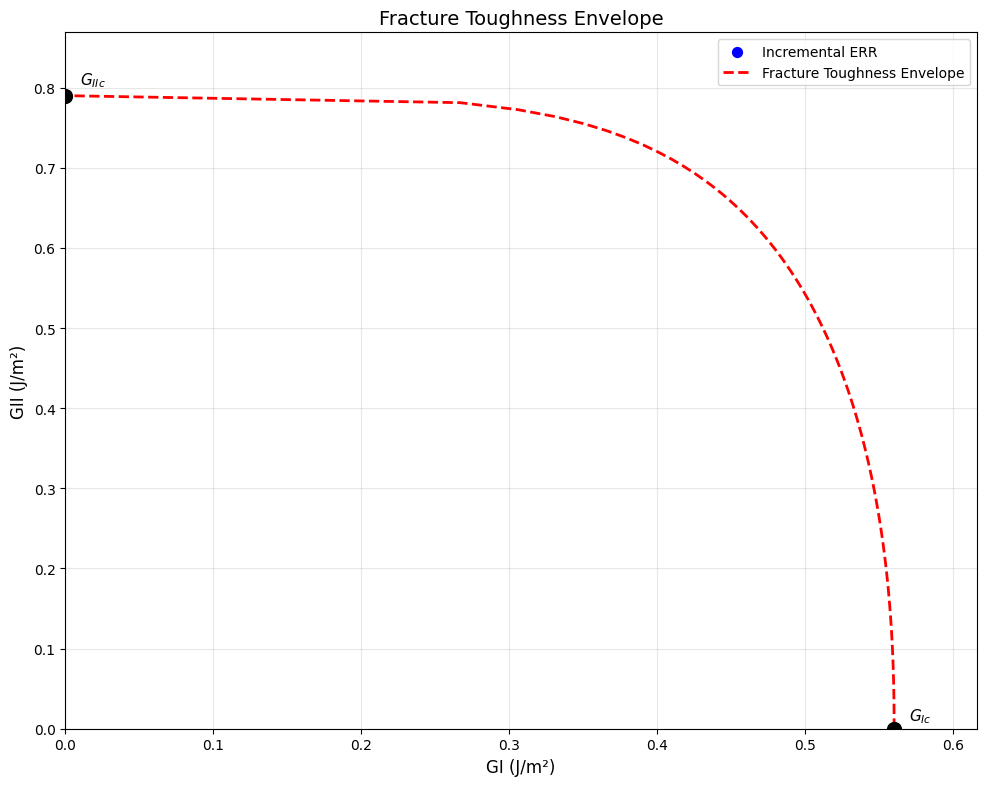

In [29]:
print("   - Generating fracture toughness envelope...")
plotter = Plotter()
fig = plotter.plot_err_envelope(
    system_model=sys_model,
    criteria_evaluator=criteria_evaluator,
    filename="err_envelope",
)

As the fracture toughness envelope function is greater than one for the minimum critical skier weight, this particular snow profile is governed by a pure stress criterion for anticrack nucleation. 

In [30]:
# Define thinner snow profile (standard snow profile A), with higher weak layer Young's Modulus
layers = [
    Layer(rho=350, h=120),
    Layer(rho=270, h=120),
    Layer(rho=180, h=120),
]
scenario_config = ScenarioConfig(
    system_type='skier',
    phi=30,
)
segments = [
    Segment(length=18000, has_foundation=True, m=0),
    Segment(length=0, has_foundation=False, m=75),
    Segment(length=0, has_foundation=False, m=0),
    Segment(length=18000, has_foundation=False, m=0),
]
weak_layer = WeakLayer(
    rho=150,
    h=30,
    E=1,
)
criteria_config = CriteriaConfig(
    stress_envelope_method='adam_unpublished',
    scaling_factor=1,
    order_of_magnitude=1,
)
model_input = ModelInput(
    scenario_config=scenario_config,
    layers=layers,
    segments=segments,
    weak_layer=weak_layer,
    criteria_config=criteria_config,
)

sys_model = SystemModel(
    model_input=model_input,
)

results: CoupledCriterionResult = criteria_evaluator.evaluate_coupled_criterion(
    system=sys_model
)

print("Algorithm convergence:", results.converged)
print("Message:", results.message)
print("Self-collapse:", results.self_collapse)
print("Pure stress criteria:", results.pure_stress_criteria)
print("Critical skier weight:", results.critical_skier_weight)
print("Initial critical skier weight:", results.initial_critical_skier_weight)
print("Crack length:", results.crack_length)
print("G delta:", results.g_delta)
print("Final error:", results.dist_ERR_envelope)
print("Max distance to failure:", results.max_dist_stress)
print("Iterations:", results.iterations)

Algorithm convergence: True
Message: No Exception encountered - Converged successfully.
Self-collapse: False
Pure stress criteria: False
Critical skier weight: 346.8349191568037
Initial critical skier weight: 341.108488248429
Crack length: 29.136286292286968
G delta: 1.0013647813490758
Final error: 0.0013647813490758054
Max distance to failure: 1.0290148348280694
Iterations: 8


The thinner snow profile, with adjusted weak layer Young's Modulus, is governed by a coupled criterion for anticrack nucleation. The critical skier weight is 346.7 kg and the associated crack length is 29 mm.

In [31]:
system = results.final_system
results = criteria_evaluator.check_crack_self_propagation(system)
print("Results of crack propagation criterion: ", results)

Segments:  [Segment(length=17976.697653089002, has_foundation=True, m=0.0), Segment(length=23.302346910997585, has_foundation=False, m=346.8349191568037), Segment(length=5.833939381289383, has_foundation=False, m=0.0), Segment(length=17994.16606061871, has_foundation=True, m=0.0)]
Results of crack propagation criterion:  (np.float64(1.2036206367817859), True)


In [32]:
# As the crack propagation criterion is not met --> investigate minimum self propagation crack boundary
initial_interval = (1, 3000)  # Interval for the crack length search (mm)

min_crack_length = criteria_evaluator.find_minimum_crack_length(system, search_interval=initial_interval)

if min_crack_length is not None:
    print(f"Minimum Crack Length for Self-Propagation: {min_crack_length} mm")
else:
    print("The search for the minimum crack length did not converge.")


Interval for crack length search:  1 3000
Calculation of fracture toughness envelope:  -0.9999595014385291 2857.9688214158086
Minimum Crack Length for Self-Propagation: (1706.9272437952422, [Segment(length=17146.53637810238, has_foundation=True, m=0.0), Segment(length=853.4636218976202, has_foundation=False, m=0.0), Segment(length=853.4636218976202, has_foundation=False, m=0.0), Segment(length=17146.53637810238, has_foundation=True, m=0.0)]) mm


The anticrack of 29.0 mm is not sufficiently long to surpass the self crack propagation boundary of 1706.4 mm. The propensity of the generated anticrack to proagate, is low.

In [33]:
layers = [
    Layer(rho=350, h=120),
    Layer(rho=270, h=120),
    Layer(rho=180, h=120),
]
scenario_config = ScenarioConfig(
    system_type='skier',
    phi=-35,
)
segments = [
    Segment(length=180000, has_foundation=True, m=0),
    Segment(length=0, has_foundation=False, m=75),
    Segment(length=0, has_foundation=False, m=0),
    Segment(length=180000, has_foundation=False, m=0),
]
weak_layer = WeakLayer(
    rho=125,
    h=30,
    E=1,
)
criteria_config = CriteriaConfig(
    stress_envelope_method='adam_unpublished',
    scaling_factor=125/250,
    order_of_magnitude=3,
)
model_input = ModelInput(
    scenario_config=scenario_config,
    layers=layers,
    segments=segments,
    weak_layer=weak_layer,
    criteria_config=criteria_config,
)

system = SystemModel(model_input=model_input)
criteria_evaluator = CriteriaEvaluator(criteria_config=criteria_config)
results: CoupledCriterionResult = criteria_evaluator.evaluate_coupled_criterion(system)


print("Algorithm convergence:", results.converged)
print("Message:", results.message)
print("Critical skier weight:", results.critical_skier_weight)
print("Crack length:", results.crack_length)
print("G delta:", results.g_delta)
print("Iterations:", results.iterations)
print("dist_ERR_envelope:", results.dist_ERR_envelope)
print("History:", results.history.incr_energies[-1])


Algorithm convergence: True
Message: No Exception encountered - Converged successfully.
Critical skier weight: 22.567736031400667
Crack length: 2344.706943056721
G delta: 1.0013453103325187
Iterations: 17
dist_ERR_envelope: 0.0013453103325187232
History: [ 0.52139802  0.56001384 -0.03861582]


In [34]:
system = results.final_system
g_delta, propagation_status = criteria_evaluator.check_crack_self_propagation(system)
print("Results of crack propagation criterion: ", propagation_status)
print("G delta: ", g_delta)

Segments:  [Segment(length=179064.88065355987, has_foundation=True, m=0.0), Segment(length=935.1193464401294, has_foundation=False, m=22.567736031400667), Segment(length=1409.5875966165913, has_foundation=False, m=0.0), Segment(length=178590.4124033834, has_foundation=True, m=0.0)]
Results of crack propagation criterion:  True
G delta:  125.93403485816587


   - Generating stress envelope...


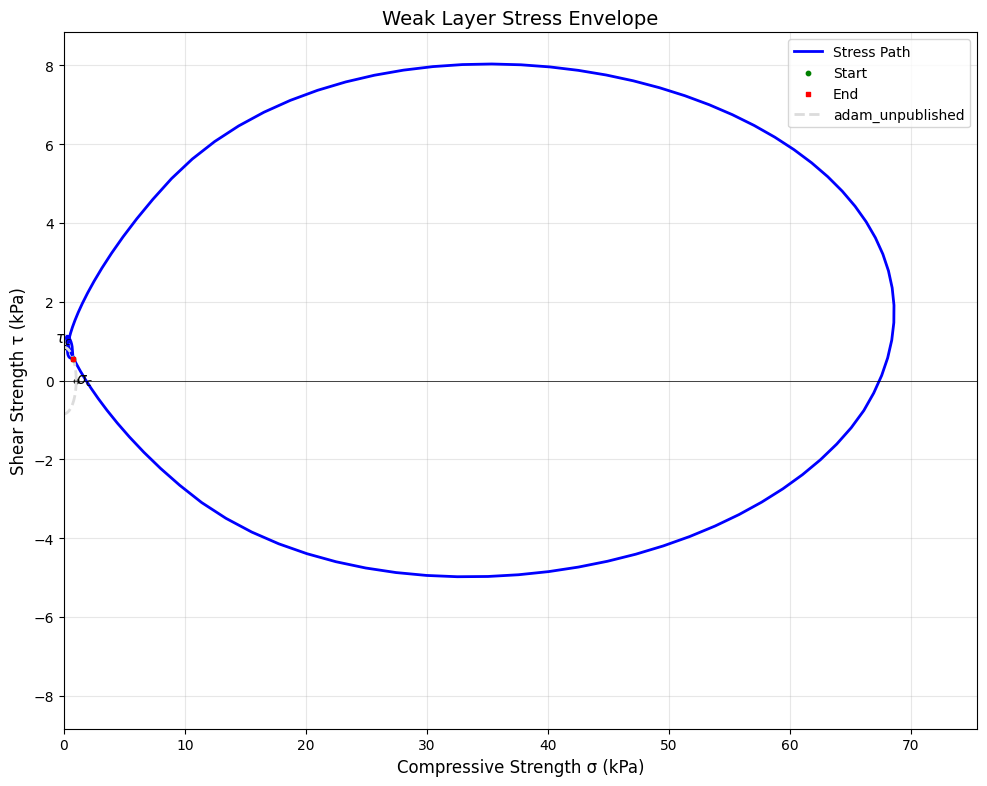

In [35]:
print("   - Generating stress envelope...")
plotter = Plotter()
plotter.plot_stress_envelope(
    system_model=system,
    criteria_evaluator=criteria_evaluator,
    all_envelopes=False,
    filename="stress_envelope",
)

   - Generating fracture toughness envelope...


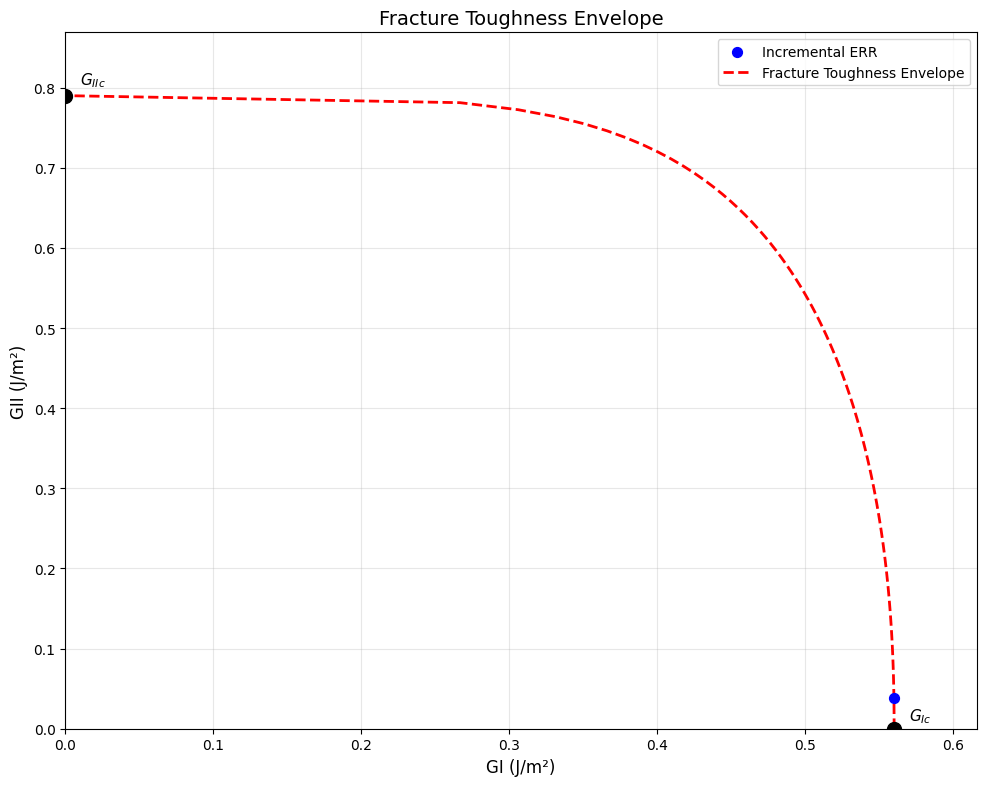

In [36]:
print("   - Generating fracture toughness envelope...")
plotter = Plotter()
fig = plotter.plot_err_envelope(
    system_model=system,
    criteria_evaluator=criteria_evaluator,
    filename="err_envelope",
)

Crack propagation is expected given the anticrack nucleation length of 2343.7 mm. Scaling stress envelope boundary and weak layer Young's Modulus with weak layer density is essential for fair evaluation of anticrack and crack propagation criteria. 